In [1]:
using Revise

In [2]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018

In [3]:
# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const Γ = 1/25e-9

# Define physical constants
const kB = BoltzmannConstant.val
;

## Potential and force for an ODT assuming a Gaussian beam profile

In [4]:
Base.@kwdef struct GaussianProfile
    λ::Float64
    w0x::Float64
    w0y::Float64
    U_max::Float64
    zRx::Float64 = π * w0x^2 / λ
    zRy::Float64 = π * w0y^2 / λ
end
;

In [5]:
wx(z, trap::GaussianProfile) = trap.w0x * sqrt(1 + z^2 / trap.zRx^2)
wy(z, trap::GaussianProfile) = trap.w0y * sqrt(1 + z^2 / trap.zRy^2)
;

In [6]:
ODT_1064_Xstate = GaussianProfile(λ=1064e-9, w0x=27.5e-6, w0y=23.3e-6, U_max=kB * 550e-6)
ODT_1064_Astate = GaussianProfile(λ=1064e-9, w0x=27.5e-6, w0y=23.3e-6, U_max=kB * 250e-6)

ODT_780_Xstate = GaussianProfile(λ=780e-9, w0x=16e-6, w0y=16e-6, U_max=kB * 285e-6)
ODT_780_Astate = GaussianProfile(λ=780e-9, w0x=16e-6, w0y=16e-6, U_max=kB * (-1000e-6))

# tweezer = GaussianProfile(λ=780e-9, w0x=15e-6, w0y=15e-6, U_max=kB * 650e-6)
;

In [7]:
"""
Potential at position `r` in a Gaussian trap.
"""
function U(r, trap::GaussianProfile)
    x, y, z = r
    wx_ = wx(z, trap)
    wy_ = wy(z, trap) 
    return trap.U_max * (1 - ((trap.w0x * trap.w0y) / (wx_ * wy_)) * exp(-2 * (x^2 / wx_^2 + y^2 / wy_^2)))
end

"""
Calculate the force at position `r` in a Gaussian trap. 
"""
function F(r, trap::GaussianProfile)
    x, y, z = r
    wx_ = wx(z, trap)
    wy_ = wy(z, trap)
    
    exp_term = exp(-2(x^2 / wx_^2 + y^2 / wy_^2))
    denom_term_x = wx_^2 * sqrt(1 + (z/trap.zRx)^2) * sqrt(1 + (z/trap.zRy)^2)
    denom_term_y = wy_^2 * sqrt(1 + (z/trap.zRx)^2) * sqrt(1 + (z/trap.zRy)^2)
    
    F_x = 4x / denom_term_x
    F_y = 4y / denom_term_y
    F_z = z * (trap.w0x / trap.zRx)^2 / denom_term_x + z * (trap.w0y / trap.zRy)^2 / denom_term_y -
        (4 * x^2 * z) / (denom_term_x * trap.zRx^2) - (4 * y^2 * z) / (denom_term_y * trap.zRy^2)

    return (-exp_term * trap.U_max / m) .* SVector(F_x, F_y, F_z)
end
;

## Calculate a grid for the potential of our trap, which we can then sample from during propagation

In [9]:
using RectiGrids, DataFrames, Interpolations

In [10]:
grid_range_rx = range(-3ODT.w0x, 3ODT.w0x, 200)
grid_range_ry = range(-3ODT.w0y, 3ODT.w0y, 200)
grid_range_rz = range(-3*(ODT.zRx + ODT.zRy) / 2, 3*(ODT.zRx + ODT.zRy) / 2, 200)
;

LoadError: UndefVarError: ODT not defined

In [11]:
grid_values = (
    rx = grid_range_rx, 
    ry = grid_range_ry, 
    rz = grid_range_rz
)
grid = RectiGrids.grid(grid_values)
forces = zeros(SVector{3, Float64}, size(grid))
;

LoadError: UndefVarError: grid_range_rx not defined

In [12]:
@time for (i, grid_value) ∈ enumerate(grid)
    forces[i] = F(grid_value, ODT)
end
;

LoadError: UndefVarError: grid not defined

In [13]:
force_interp = interpolate(forces, BSpline(Cubic(Line(OnGrid()))))
force_sinterp = Interpolations.scale(force_interp, grid_values...)
;

LoadError: UndefVarError: forces not defined

Not actually that helpful since the evalution of the force itself is already plenty fast... Maybe the interpolation could be made better than pure evaluation if we use constant interpolation with a relatively fine grid (so essentially "look up") or a linear interpolation. 

## Run the propagation

In [8]:
function make_distributions_harmonic(T, trap)
    ωx = sqrt(4 * trap.U_max / (m * trap.w0x^2))
    ωy = sqrt(4 * trap.U_max / (m * trap.w0y^2))
    ωz = sqrt(2 * trap.U_max / (m * trap.zRx * trap.zRy))
    σ = sqrt(kB * T / m)
    σ_rx = σ / ωx
    σ_ry = σ / ωy
    σ_rz = σ / ωz
    σ_vx = σ_vy = σ_vz = σ
    r = (Normal(0, σ_rx), Normal(0, σ_ry), Normal(0, σ_rz))
    v = (Normal(0, σ_vx), Normal(0, σ_vy), Normal(0, σ_vz))
    a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
    return r, v, a
end
;

In [9]:
function make_distributions_gaussian(T, σ_r)
    σ = sqrt(kB * T / m)
    σ_rx = σ_ry = σ_rz = σ_r
    σ_vx = σ_vy = σ_vz = σ
    r = (Normal(0, σ_rx), Normal(0, σ_ry), Normal(0, σ_rz))
    v = (Normal(0, σ_vx), Normal(0, σ_vy), Normal(0, σ_vz))
    a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
    return r, v, a
end
;

Consider we have data for a cooling curve of the form $T(t) = T_\text{start} e^{-t / \tau_\text{cooling}} - T_\text{min}$. This functional form implies that the cooling efficiency is a function of time, or, equivalently, a function of the current temperature (which is decreasing with time). We wish to figure out the cooling rate at a given temperature, which we define as $dT(T)/dt$. Given $T(t)$, we can compute this quantity as follows. First,

$$
\frac{dT(t)}{dt} = - \frac{T_\text{start}}{\tau_\text{cooling}} e^{-t / \tau_\text{cooling}}.
$$

Moreover, we can invert the relation $T(t)$ to compute $t(T)$:

$$
t(T) = -\tau_\text{cooling} \ln \left( \frac{T - T_\text{min}}{T_\text{start}} \right).
$$

Plugging this into the above relation, we find

$$
\frac{dT(T)}{dt} = \frac{T_\text{min} - T}{\tau_\text{cooling}}.
$$

As we might have expected, any dependence on the initial temperature $T_\text{start}$ drops out, and we find a linear cooling rate as a function of temperature that is zero for $T \rightarrow T_\text{min}$. In terms of the velocity, we can also write

$$
\frac{dT(v)}{dt} = \frac{m}{2}\frac{v_\text{min}^2 - v^2}{\tau_\text{cooling}}.
$$

In [1]:
cooling_rate(T, T_min, τ_cooling) = T > T_min ? (T_min - T) / τ_cooling : 0
;

How does the cooling rate relates to a cooling force? We know that

$$
\frac{3}{2}k_B T = \frac{1}{2} mv^2,
$$

and taking the derivative on both sides, we find

$$
\frac{3}{2}k_B \frac{dT}{dt} = \frac{1}{2} m(2av) = mav \implies a = \frac{3}{2} \frac{k_B}{mv} \frac{dT}{dt},
$$

so we can relate the cooling rate to a force given by

$$
F = \frac{3}{2} \frac{k_B}{v} \frac{dT}{dt} = \frac{3}{2} \frac{k_B}{v} \frac{m}{2}\frac{v_\text{min}^2 - v^2}{\tau_\text{cooling}}
$$

What about the effect of anti-trapping when excited to the $\tilde{A}$ state? Let's make a simple model in which there is some probability for being in the $\tilde{A}$ state at any point in time, and if we deem that the molecule is indeed in the $\tilde{A}$ state, we modify the force to reflect the trapping potential of the $\tilde{A}$ state. The probability of being in the excited state is $P(\tilde{A}) = R_\text{scatt} / 2\Gamma$, where $\Gamma = 1/25~\text{ns}$ is the linewidth of the $\tilde{A}$ state and $R_\text{scatt}$ is the scattering rate. 

In [11]:
using LinearAlgebra

discard(r, v) = false
is_detectable(r, p) = (abs(r[1]) < 10p.trap_X.w0x) && (abs(r[2]) < 10p.trap_X.w0y) && (abs(r[3]) < 10 * max(p.trap_X.zRx, p.trap_X.zRy))

function update(particles, p, s, dt)
    p.time_ += dt
    for i in 1:size(particles, 1)
        # Each particle has a distinct `idx`, which we'll need to use when saving data
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)
function f(idx, r, v, p)
    
    # Check if the particle is in the X or A state, which will change which instantaneous trapping potential is seen
    prob_A = p.R_scatt / 2Γ
    if rand() > prob_A
        F_trap = F(r, p.trap_X)
    else
        F_trap = F(r, p.trap_A)
    end
    
    # Calculate the force due to the cooling light
    T = m * norm(v)^2 / (3kB)
    F_cooling = sign.(v) .* ((3/2) * (kB / norm(v)) * cooling_rate(T, p.T_min, p.τ_cooling))
    
    return F_trap + gravity(r) + p.cooling_on .* (F_cooling / m)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
        
        # Save temperatures
        v = particles.v[i]
        T = m * norm(v)^2 / (3kB)
        push!(s.Ts[idx], T)
    end
    return nothing
end
;

In [12]:
T = UnitsToValue.@with_unit 800 "μK"
σ_r = 0.5e-3
r, v, a = make_distributions_gaussian(T, σ_r)
;

In [13]:
n = 10000
save_every = 500
delete_every = 50
dt_min = 1e-9
dt_max = 1e-6
abstol = 1e-5
dt = 1e-6
t_end = 0.1
max_steps = Int64(ceil(t_end / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-6
;

In [14]:
time_ = 0.0
detectable = zeros(Bool, n)
particles = StructArray{Particle}(undef, n)

# Arrays for data to save
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
Ts = [Float64[] for _ ∈ 1:length(particles)]

cooling_on = true
p = MutableNamedTuple(time_=time_, trap_X=ODT_780_Xstate, trap_A=ODT_780_Astate, cooling_on=cooling_on, R_scatt=500e3, T_min=40e-6, τ_cooling=200e-6)
# p = MutableNamedTuple(time_=time_, trap_X=ODT_1064_Xstate, trap_A=ODT_1064_Astate, cooling_on=cooling_on, R_scatt=500e3)
s = @params (detectable, trajectories, Ts)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

  6.582660 seconds (3.44 M allocations: 462.474 MiB, 0.45% gc time, 14.04% compilation time)


0.0147

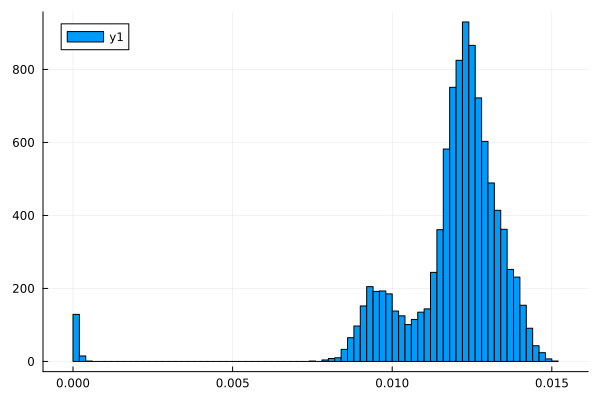

In [15]:
norm.([traj[end] for traj ∈ s.trajectories]) |> histogram

## 2D grid scan of trapping fraction versus ($U(\tilde{A})$, $R_\text{scatt}$)

In [ ]:
using ProgressMeter

In [ ]:
Us = (0:1:5) .* 1e-3
R_scatts = (0:5000:50000) .* 1e3

trapped_fractions = zeros(length(Us), length(R_scatts))

@showprogress for (i, U) ∈ enumerate(Us)
    
    ODT_Xstate = GaussianProfile(λ=780e-9, w0x=25e-6, w0y=25e-6, U_max=kB * 950e-6)
    ODT_Astate = GaussianProfile(λ=780e-9, w0x=25e-6, w0y=25e-6, U_max=kB * (-U))
    
    for (j, R_scatt) ∈ enumerate(R_scatts)
        
        time_ = 0.0
        detectable = zeros(Bool, n)
        particles = StructArray{Particle}(undef, n)            
            
        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        Ts = [Float64[] for _ ∈ 1:length(particles)]

        cooling_on = true
        p = MutableNamedTuple(time_=time_, trap_X=ODT_Xstate, trap_A=ODT_Astate, cooling_on=cooling_on, R_scatt=R_scatt)
        s = @params (detectable, trajectories, Ts)

        propagate_particles!(r, v, a, 
            alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true
        )

        trapped_fractions[i,j] = mean(s.detectable)
    end
end

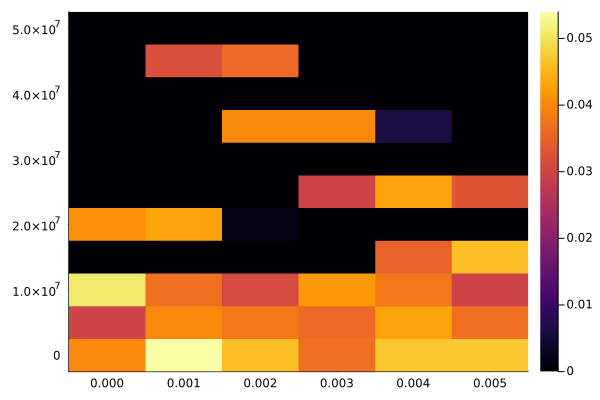

In [769]:
heatmap(Us, R_scatts, trapped_fractions)

## Trapping fraction versus $T_\text{min}$ for 1064 nm and 780 nm ODTs

In [16]:
using ProgressMeter

In [24]:
τ_cooling = 200e-6
R_scatt = 500e3
;

In [26]:
T_mins = (10:50:210) .* 1e-6
U_times = 1:5

trapped_fractions_1064 = zeros(length(T_mins))
trapped_fractions_780 = zeros(length(T_mins), length(U_times))

ODT_1064_Xstate = GaussianProfile(λ=1064e-9, w0x=27.5e-6, w0y=23.3e-6, U_max=kB * 550e-6)
ODT_1064_Astate = GaussianProfile(λ=1064e-9, w0x=27.5e-6, w0y=23.3e-6, U_max=kB * 250e-6)

@showprogress for (i, T_min) ∈ enumerate(T_mins)

    time_ = 0.0
    detectable = zeros(Bool, n)
    particles = StructArray{Particle}(undef, n)            

    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    Ts = [Float64[] for _ ∈ 1:length(particles)]

    cooling_on = true
    p = MutableNamedTuple(time_=time_, trap_X=ODT_1064_Xstate, trap_A=ODT_1064_Astate, cooling_on=cooling_on, R_scatt=R_scatt, T_min=T_min, τ_cooling=τ_cooling)
    s = @params (detectable, trajectories, Ts)

    propagate_particles!(r, v, a, 
        alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true
    )

    trapped_fractions_1064[i] = mean(s.detectable)
    
    for (j, U_time) ∈ enumerate(U_times)
        
        ODT_780_Xstate = GaussianProfile(λ=780e-9, w0x=16e-6, w0y=16e-6, U_max=U_time * kB * 285e-6)
        ODT_780_Astate = GaussianProfile(λ=780e-9, w0x=16e-6, w0y=16e-6, U_max=U_time * kB * (-1000e-6))
        
        time_ = 0.0
        detectable = zeros(Bool, n)
        particles = StructArray{Particle}(undef, n)            

        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        Ts = [Float64[] for _ ∈ 1:length(particles)]

        cooling_on = true
        p = MutableNamedTuple(time_=time_, trap_X=ODT_780_Xstate, trap_A=ODT_780_Astate, cooling_on=cooling_on, R_scatt=R_scatt, T_min=T_min, τ_cooling=τ_cooling)
        s = @params (detectable, trajectories, Ts)

        propagate_particles!(r, v, a, 
            alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true
        )

        trapped_fractions_780[i,j] = mean(s.detectable)
        
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:48


In [98]:
using LaTeXStrings

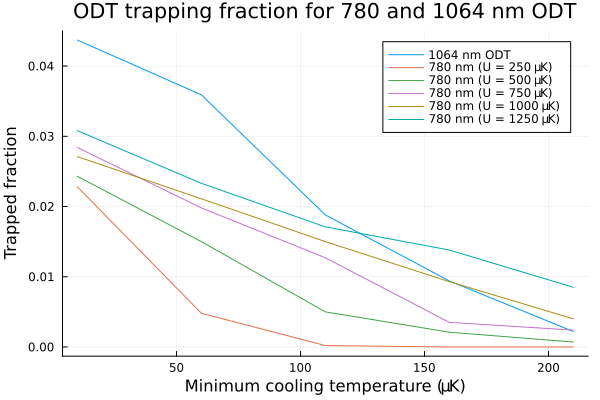

In [121]:
plot(T_mins .* 1e6, trapped_fractions_1064, label="1064 nm ODT")
plot!(T_mins .* 1e6, trapped_fractions_780, label=["780 nm (U = 250 \\muK)" "780 nm (U = 500 \\muK)" "780 nm (U = 750 \\muK)" "780 nm (U = 1000 \\muK)" "780 nm (U = 1250 \\muK)"])
title!("ODT trapping fraction for 780 and 1064 nm ODT")
xlabel!("Minimum cooling temperature (\\muK)")
ylabel!("Trapped fraction")